In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm.notebook import trange

In [2]:
%matplotlib inline

In [3]:
_ = plt.style.use('scientific')
_ = torch.manual_seed(7)

# Random Multi-Channel Spike Sequence

In [4]:
from rsnn.spike_sequences.sampling import sample_spike_sequences

In [7]:
T, Tr = 200, 20 # in ms # it worked with T = 100, 200, 500(?)
L = 100

In [8]:
N, Nr = T, Tr # one time unit = 1ms

spike_sequences = sample_spike_sequences(N, Nr, L)

# Random Neural Network

In [7]:
K = 500

wb = 0.1
taub = 60
theta = 1.

beta = 2 # spreading hyperparameter
impulse_resp = lambda t_: (t_ >= 0) * t_ / beta * torch.exp(1 - t_ / beta)
impulse_resp_deriv = lambda t_: (t_ >= 0) * 1 / beta * (1 - t_ / beta) * torch.exp(1 - t_ / beta)

delays = torch.FloatTensor(L, K).uniform_(0, taub)
sources = torch.randint(0, L, (L, K))
weights = torch.FloatTensor(L, K).uniform_(-wb, wb)

# Memorization

In [8]:
device = "cpu"

## Firing Template

In [9]:
from rsnn.memorization.template import parse_spike_sequences
from rsnn.memorization.utils import compute_observation_matrices

In [10]:
eps = 1 # firing surrounding window
b = 0.5 # maximum level in silent period
a = 0.5 # minimum slope in activity period

In [11]:
firing_indices, active_period_indices, silent_period_indices = parse_spike_sequences(spike_sequences, Nr, eps)

In [12]:
C = compute_observation_matrices(spike_sequences, delays, sources, Nr, impulse_resp, impulse_resp_deriv).to(device)

## Alternating Maximization

In [13]:
from rsnn.memorization.prior import compute_box_prior
from rsnn.memorization.posterior import compute_posterior

In [14]:
gamma_wb = 10.
gamma_b = 3.
gamma_a = 5.
gamma_theta = 10.

In [15]:
mw_f = weights.to(device, copy=True)
Vw_f = torch.ones(L, K, device=device)

mz_b = torch.zeros(N, L, 2, device=device)
Vz_b = torch.ones(N, L, 2, device=device)

mz_b[silent_period_indices[:, 0], silent_period_indices[:, 1], 0] = b
mz_b[active_period_indices[:, 0], active_period_indices[:, 1], 1] = a
mz_b[firing_indices[:, 0], firing_indices[:, 1], 0] = theta

In [16]:
for itr in trange(200): # previously 500
    # posteriors
    mw, Vw, mz = compute_posterior(mw_f, Vw_f, mz_b, Vz_b, C)
    
    # priors
    mw_f, Vw_f = compute_box_prior(mw, -wb, wb, gamma_wb)
        
    mz_b = torch.zeros(N, L, 2, device=device)
    Vz_b = 1e9 * torch.ones(N, L, 2, device=device)
    (
        mz_b[silent_period_indices[:, 0], silent_period_indices[:, 1], 0],
        Vz_b[silent_period_indices[:, 0], silent_period_indices[:, 1], 0],
    ) = compute_box_prior(mz[silent_period_indices[:, 0], silent_period_indices[:, 1], 0], None, b, gamma_b)
    (
        mz_b[active_period_indices[:, 0], active_period_indices[:, 1], 1],
        Vz_b[active_period_indices[:, 0], active_period_indices[:, 1], 1],
    ) = compute_box_prior(mz[active_period_indices[:, 0], active_period_indices[:, 1], 1], a, None, gamma_a)
    mz_b[firing_indices[:, 0], firing_indices[:, 1], 0], Vz_b[firing_indices[:, 0], firing_indices[:, 1], 0] = compute_box_prior(
        mz[firing_indices[:, 0], firing_indices[:, 1], 0], theta, theta, gamma_theta
    )

  0%|          | 0/200 [00:00<?, ?it/s]

### Bounded Weights?

In [17]:
mw.flatten().abs().max(), wb

(tensor(0.1000), 0.1)

### Cross Firing Threshold at Firing Times?

In [18]:
(mz[firing_indices[:, 0], firing_indices[:, 1], 0] - theta).abs().max()

tensor(6.5565e-07)

### Minimum Raise Around Firing?

In [19]:
(mz[active_period_indices[:, 0], active_period_indices[:, 1], 1]).min(), a

(tensor(0.9092), 1.0)

### Maximum Potential at Silent Period?

In [20]:
(mz[silent_period_indices[:, 0], silent_period_indices[:, 1], 0]).max(), b

(tensor(0.5000), 0.5)

### Visualisation

In [21]:
from rsnn.visualisation.visualisation import add_background

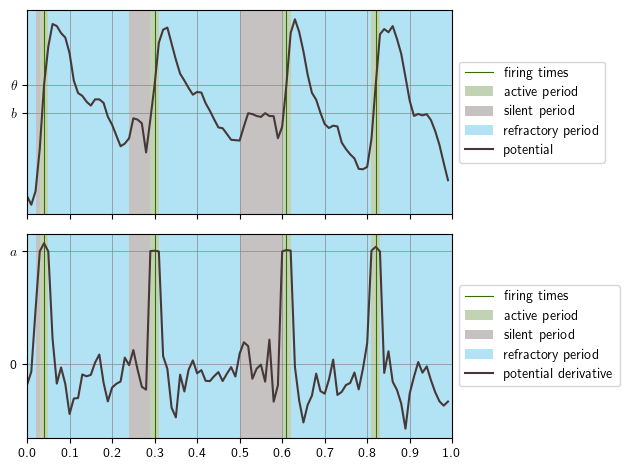

In [22]:
fig, axes = plt.subplots(2, 1, sharex=True)

axes[0], handles = add_background(axes[0], torch.argwhere(spike_sequences[:, 42]).squeeze(), N, Nr, eps)
handles += axes[0].plot(mz[:, 42, 0], label="potential")
axes[0].set_yticks([b, theta])
axes[0].set_yticklabels(["$b$", r"$\theta$"])
axes[0].legend(handles=handles, loc="center left", bbox_to_anchor =(1, 0.5))

axes[1], handles = add_background(axes[1], torch.argwhere(spike_sequences[:, 42]).squeeze(), N, Nr, eps)
handles += axes[1].plot(mz[:, 42, 1], label="potential derivative")
axes[1].set_yticks([0, a])
axes[1].set_yticklabels([0, "$a$"])
axes[1].legend(handles=handles, loc="center left", bbox_to_anchor =(1, 0.5))

axes[0].set_xlim(0, T)
axes[0].set_xticks(np.linspace(0, T, 11))
axes[0].set_xticklabels(np.linspace(0, 1, 11).round(1))

fig.tight_layout()
fig.savefig("firing_template_matching.pdf", format="pdf", bbox_inches="tight")

# Matrix Analysis

In [23]:
from rsnn.robustness.temporal_stability import compute_jitter_transition_matrices, compute_v0

In [24]:
A = compute_jitter_transition_matrices(spike_sequences, weights, delays, sources, Tr, impulse_resp_deriv)

In [25]:
Phi = torch.eye(A.size(1), A.size(2))
for n in range(N):
    Phi = A[n]@Phi

In [26]:
eigvals = torch.linalg.eigvals(Phi)

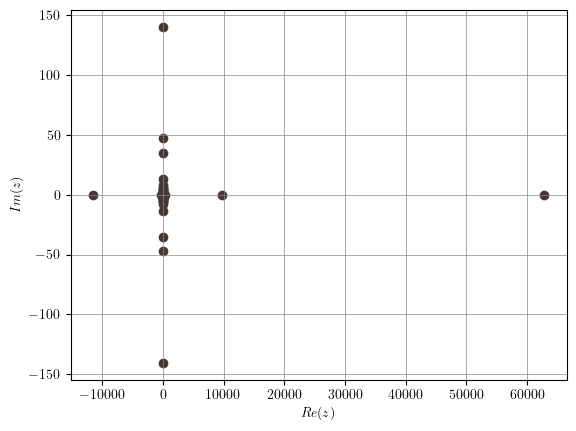

In [27]:
_ = plt.scatter(eigvals.real, eigvals.imag)
_ = plt.xlabel("$Re(z)$")
_ = plt.ylabel("$Im(z)$")

In [28]:
values, _ = eigvals.abs().topk(5)
if values[1] < 1:
    v0 = compute_v0(Phi)
    indices = torch.arange(v0.size(0))
    colors = ["C3" if v0i > 0 else "C1" for v0i in v0 ]
    _ = plt.bar(indices, v0, color=colors)
else:
    print("not stable")

not stable


# Network Dynamics

In [29]:
from rsnn.simulation.simulation import simulate
from rsnn.simulation.utils import get_input, compute_drift
from rsnn.visualisation.visualisation import add_spike_sequences

In [30]:
references = [(torch.argwhere(spike_sequence).flatten()).tolist() for spike_sequence in torch.unbind(spike_sequences, -1)]

In [31]:
firing_times = [[],[],[],[],[]] # init 5 simulations

In [32]:
noisy_references = get_input(references, 0, 0, N)
firing_times[0] = simulate(sources, delays, mw, theta, Nr, impulse_resp, noisy_references, 10*N, 0.001)
compute_drift(firing_times[0], references, N, 9)

Simulating:   0%|          | 0/1000 [00:00<?, ?it/s]

(0.015616455115377903, 0.0005383265670388937)

In [33]:
noisy_references = get_input(references, 0, Tr, N)
firing_times[1] = simulate(sources, delays, mw, theta, Nr, impulse_resp, noisy_references, 10*N, 0.001)
compute_drift(firing_times[1], references, N, 9)

Simulating:   0%|          | 0/1000 [00:00<?, ?it/s]

(0.20030613243579865, 0.0005460416432470083)

In [34]:
noisy_references = get_input(references, 0, 2, N)
firing_times[2] = simulate(sources, delays, mw, theta, Nr, impulse_resp, noisy_references, 10*N, 0.001)
compute_drift(firing_times[2], references, N, 9)

Simulating:   0%|          | 0/1000 [00:00<?, ?it/s]

(0.23577606678009033, 0.0006458903662860394)

In [35]:
noisy_references = get_input(references, 0, 5, N)
firing_times[3] = simulate(sources, delays, mw, theta, Nr, impulse_resp, noisy_references, 10*N, 0.001)
compute_drift(firing_times[3], references, N, 9)

Simulating:   0%|          | 0/1000 [00:00<?, ?it/s]

(53.22203063964844, 0.06295459717512131)

In [36]:
noisy_references = get_input(references, 0, 10, N)
firing_times[4] = simulate(sources, delays, mw, theta, Nr, impulse_resp, noisy_references, 10*N, 0.001)
compute_drift(firing_times[4], references, N, 9)

Simulating:   0%|          | 0/1000 [00:00<?, ?it/s]

The network is dead...
The network cannot synchronize with the reference...


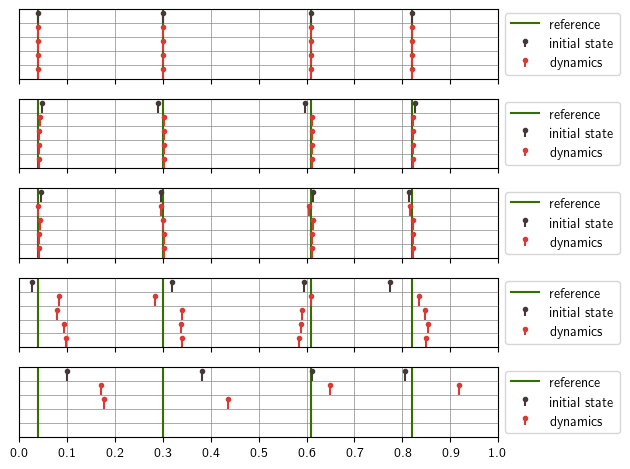

In [37]:
fig, axes = plt.subplots(5, 1, sharex=True)

for i in range(5):
    axes[i] = add_spike_sequences(axes[i], firing_times[i][42], N, 4*N, references[42])
    
fig.tight_layout()
fig.savefig("dynamics.pdf", format="pdf", bbox_inches="tight")